In [1]:
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDRegressor, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,GridSearchCV

In [2]:
path_21 = 'players_21.csv'
path_22 = 'players_22.csv'

with open(path_21) as dataset_21, open(path_22) as dataset_22:
    fifa_21 = pd.read_csv(path_21)
    fifa_22 = pd.read_csv(path_22, low_memory=False)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")

drop = []
for col in fifa_21.columns:
    missing = (len(fifa_21[col]) - fifa_21[col].count())/len(fifa_21[col]) * 100
    if missing > 30:
        print(f'{col} = {round(missing, 2)}%')
        drop.append(col)

fifa_21.drop(columns = drop, inplace = True)
fifa_22.drop(columns = drop, inplace = True)

print("\nFIFA 21 Dataset Shape: " + str(fifa_21.shape))
print("FIFA 22 Dataset Shape: " + str(fifa_22.shape) + "\n")

FileNotFoundError: ignored

We are dropping all the columns that have more than 30% of their values missing because imputing them could create a bias.

In [ ]:
ovr_21 = fifa_21[['overall']]
ovr_22 = fifa_22[['overall']]
correlate = fifa_21.corr(numeric_only = True)['overall'].sort_values(ascending=False)
keys = correlate.keys()
values = correlate.values
keys_to_use = []
for key,val in zip(keys, values):
    if(val>0.45): # 0.1
        keys_to_use.append(key)
keys_to_use.remove('potential')
# keys_to_use.remove('release_clause_eur')
# keys_to_use.remove('wage_eur')
# keys_to_use.remove('value_eur')
# keys_to_use.remove('international_reputation')

train_21 = fifa_21[keys_to_use]
train_22 = fifa_22[keys_to_use]
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']

# **Exploratory Data Analysis**

Correlation Matrix of the numeric attributes

In [ ]:
train_21.corr()

,overall,movement_reactions,passing,mentality_composure,dribbling,release_clause_eur,wage_eur,value_eur,power_shot_power,physic,mentality_vision,attacking_short_passing,shooting,skill_long_passing,age
overall,1.000000,0.867234,0.711521,0.705252,0.641097,0.626277,0.592452,0.558493,0.558372,0.530386,0.509087,0.502191,0.488315,0.487147,0.468197
movement_reactions,0.867234,1.000000,0.653151,0.688978,0.576160,0.555200,0.527923,0.494737,0.522892,0.489144,0.519531,0.506056,0.469446,0.481509,0.456416
passing,0.711521,0.653151,1.000000,0.707234,0.834238,0.459203,0.433564,0.408526,0.653926,0.164542,0.879086,0.903299,0.654703,0.850185,0.339925
mentality_composure,0.705252,0.688978,0.707234,1.000000,0.621525,0.443632,0.436807,0.394452,0.630195,0.412418,0.666859,0.734098,0.551678,0.687184,0.361039
dribbling,0.641097,0.576160,0.834238,0.621525,1.000000,0.445306,0.403073,0.398410,0.663759,-0.005488,0.805310,0.709326,0.769547,0.564810,0.183414
release_clause_eur,0.626277,0.555200,0.459203,0.443632,0.445306,1.000000,0.842814,0.978579,0.349040,0.241639,0.363914,0.328479,0.336230,0.310698,0.071333
wage_eur,0.592452,0.527923,0.433564,0.436807,0.403073,0.842814,1.000000,0.810496,0.344163,0.245962,0.345053,0.319667,0.313481,0.308607,0.163121
value_eur,0.558493,0.494737,0.408526,0.394452,0.398410,0.978579,0.810496,1.000000,0.306622,0.214611,0.325806,0.293055,0.297133,0.275035,0.045377
power_shot_power,0.558372,0.522892,0.653926,0.630195,0.663759,0.349040,0.344163,0.306622,1.000000,0.214219,0.676919,0.571844,0.858489,0.528186,0.267956
physic,0.530386,0.489144,0.164542,0.412418,-0.005488,0.241639,0.245962,0.214611,0.214219,1.000000,0.047088,0.291787,0.020286,0.267122,0.440533


Text(0.5, 1.0, 'Player Age Distribution')

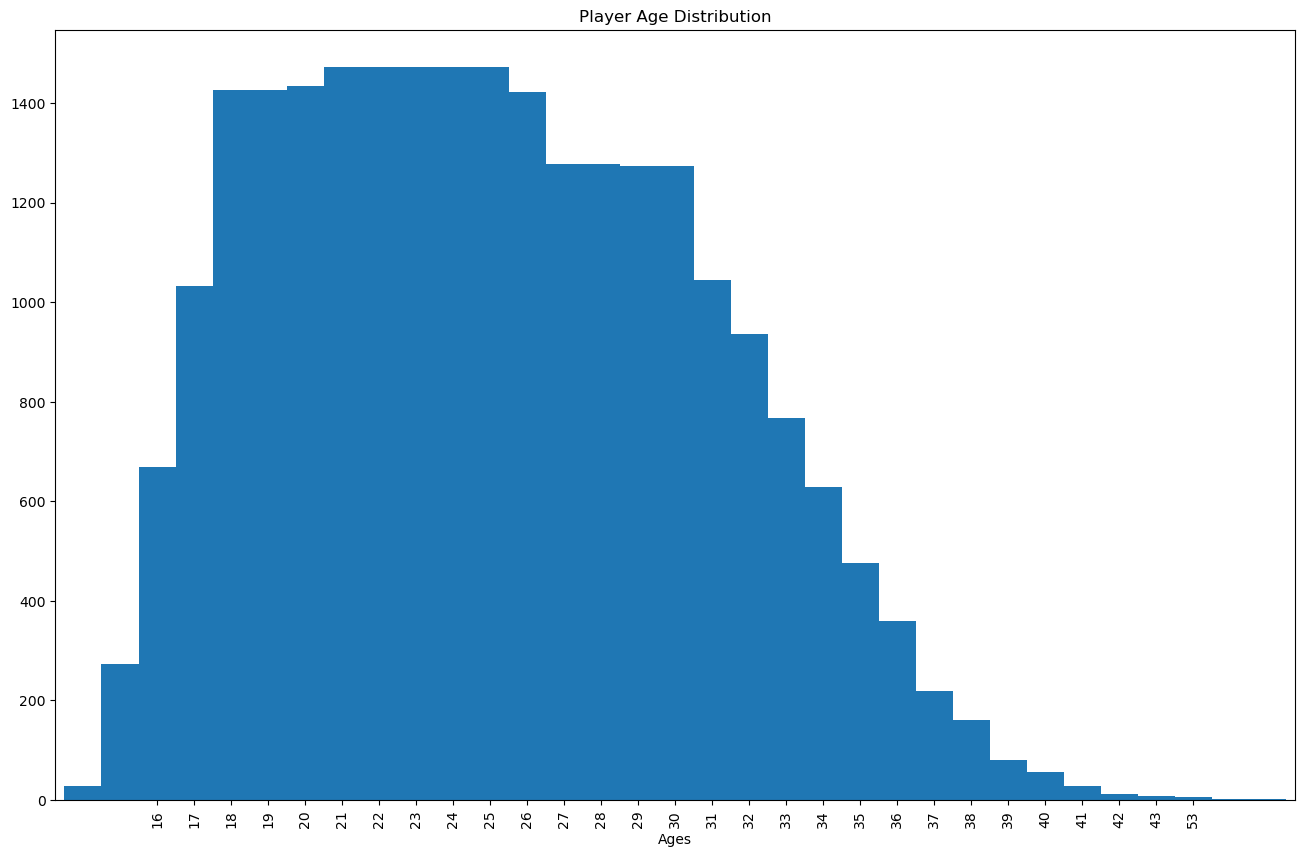

In [ ]:
age = fifa_21['age']
bins=np.arange(0, 60, 1)
pd.cut(age, bins=bins, labels=bins[1:]).astype(int).value_counts().sort_index().plot.bar(width=5, figsize=(16,10))
plt.xlabel('Ages')
plt.xticks(rotation=90)
plt.title('Player Age Distribution')

**A graph showing the player age distribution**

<Axes: xlabel='overall', ylabel='wage_eur'>

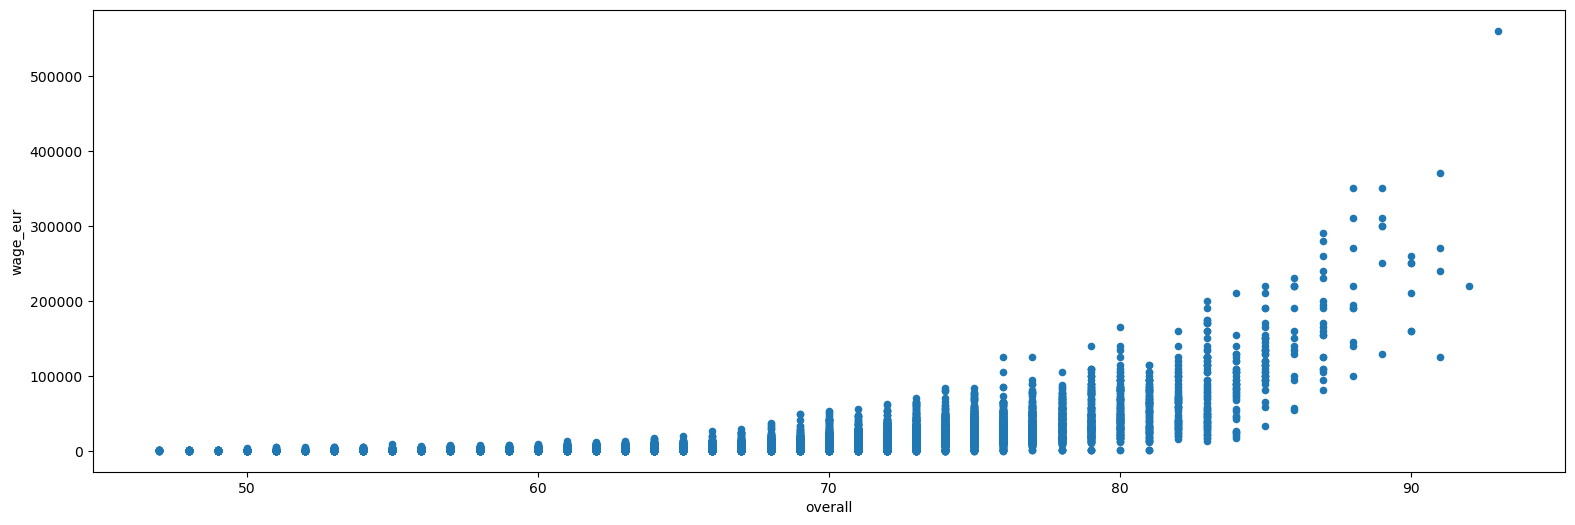

In [ ]:
fifa_21.plot(kind="scatter", x="overall", y="wage_eur", figsize=(19,6))

**A scatterplot of the relationship between a player's wage and their overall rating**

We see that generally the better a player is, the more they are paid. This could be a good attribute for prediction

<Axes: xlabel='overall', ylabel='value_eur'>

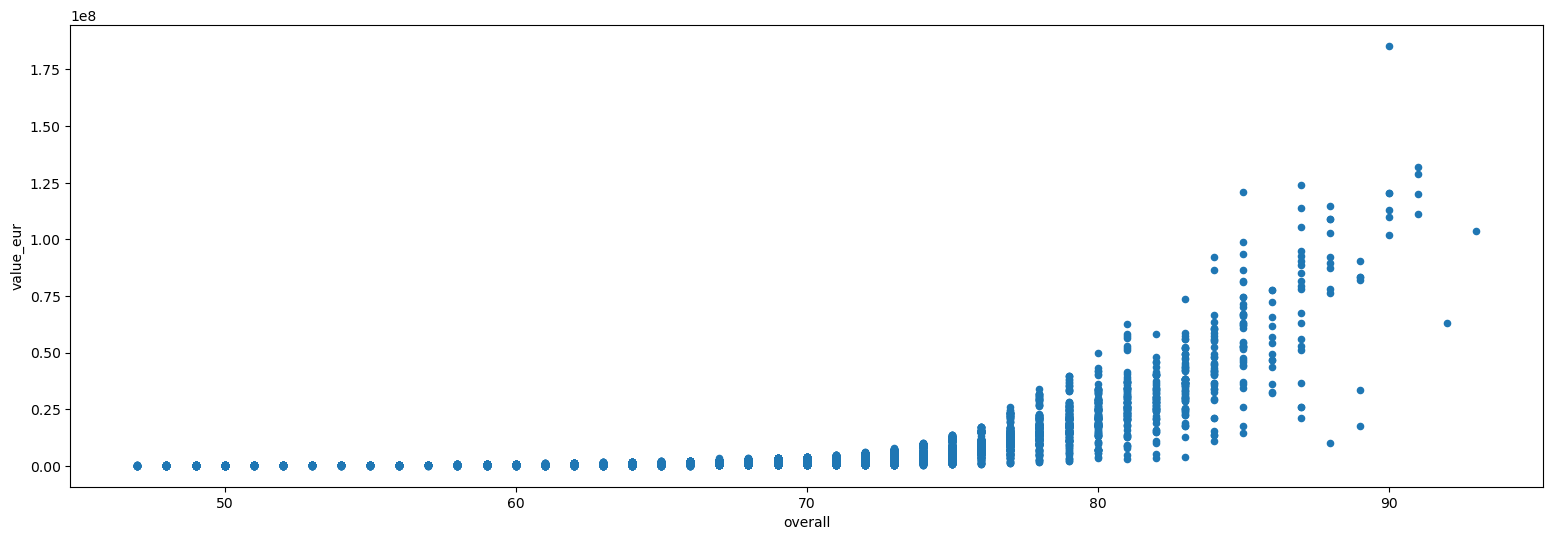

In [ ]:
fifa_21.plot(kind="scatter", x="overall", y="value_eur", figsize=(19,6))

**A scatterplot of the relationship between a player's value and their overall rating**

The scatterplot shows that the better a player is, the higher their value is. This could mean the value will be a good attribute for predicting the player's overall rating

<Axes: xlabel='overall', ylabel='age'>

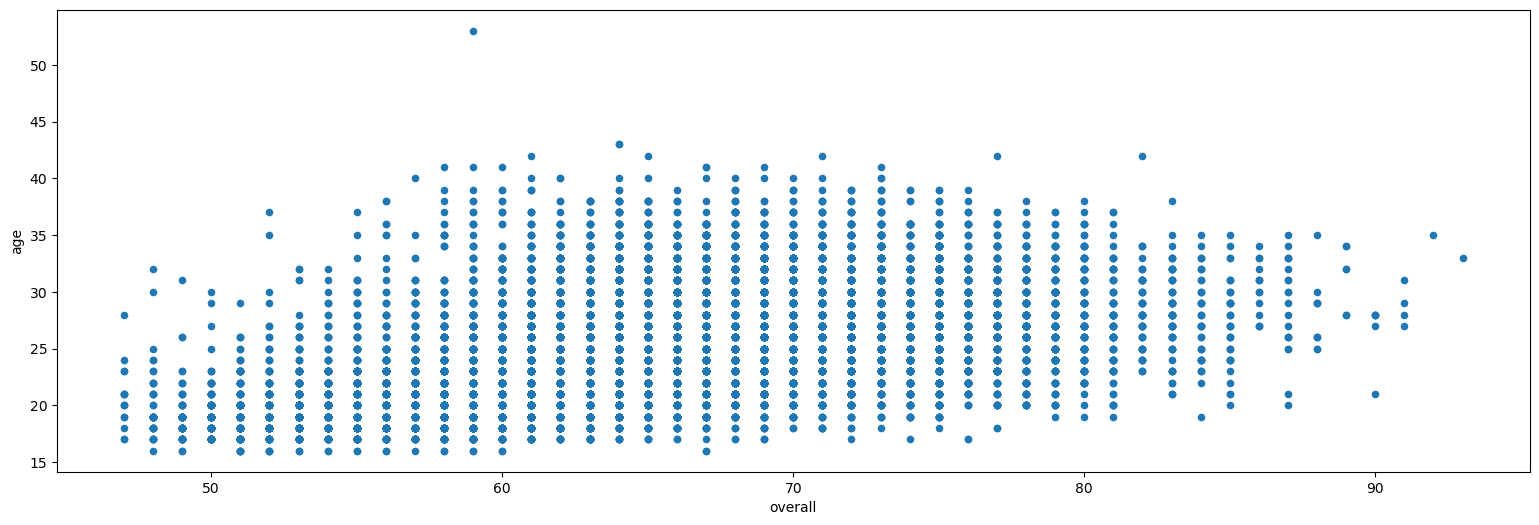

In [ ]:
fifa_21.plot(kind="scatter", x="overall", y="age", figsize=(19,6))

# **Imputation and Scaling**

In [ ]:
imp = SimpleImputer()
imp.fit(train_21)
imputed_data=imp.fit_transform(train_21)
train_21_imp=pd.DataFrame(imputed_data, columns=train_21.columns)

imputed_data = imp.fit_transform(train_22)
train_22_imp=pd.DataFrame(imputed_data, columns=train_22.columns)

In [ ]:
train_21_imp.drop(columns='overall', inplace=True)
train_22_imp.drop(columns='overall', inplace=True)

Dropping the overall from the data for training

In [ ]:
sc = StandardScaler()
scaled = sc.fit_transform(train_21_imp)
train_21 = pd.DataFrame(scaled, columns = train_21_imp.columns)

scaled = sc.fit_transform(train_22_imp)
train_22 = pd.DataFrame(scaled, columns = train_22_imp.columns)

Randomise the arrangement of the rows in each dataframe

In [ ]:
# train_21 = pd.concat([train_21, ovr_21], axis = 1).sample(frac=1)
# train_22 = pd.concat([train_22, ovr_22], axis = 1).sample(frac=1)
train_21 = pd.concat([train_21, ovr_21], axis = 1)
train_22 = pd.concat([train_22, ovr_22], axis = 1)

In [ ]:
ovr_21 = train_21['overall']
ovr_22 = train_22['overall']
train_21.drop(columns='overall', inplace=True)
train_22.drop(columns='overall', inplace=True)

# **Model Training**

In [ ]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators = 1000)
g_reg = GradientBoostingRegressor(random_state=42, init = rf, n_estimators=1000)
sv = SVR()
vc = VotingRegressor(estimators=[('random_forest', rf), ('g_reg', g_reg), ('xgb', xgb_reg)])

In [ ]:
for reg in (rf, xgb_reg, g_reg, sv, vc):
    Xtrain,Xtest,Ytrain,Ytest=train_test_split(train_21,ovr_21,test_size=0.2,random_state=42)
    reg.fit(Xtrain, Ytrain)
    y_pred = reg.predict(Xtest)
    mse = np.sqrt(mean_squared_error(y_pred, Ytest))
    mae = mean_absolute_error(y_pred, Ytest)
    r2 = r2_score(y_pred, Ytest)
    print(f"The {reg.__class__.__name__} model had {round(mae, 4)} MAE, {round(mse, 4)} RMSE and {round(r2, 4)} R2 Score")

In [ ]:
cv=KFold(n_splits=3)
param_grid = [
{'bootstrap': [True], 'n_estimators': [10, 30 ,50, 100, 200, 500], 'random_state':[42], 'n_jobs':[-1]},
{'bootstrap': [False], 'n_estimators': [10, 30 ,50, 100, 200, 500], 'random_state':[42], 'n_jobs':[-1]},
]
grid_search = GridSearchCV(rf, param_grid, cv=5,scoring='neg_mean_absolute_error',return_train_score=True)
grid_search.fit(train_21, ovr_21)

In [ ]:
model = grid_search.best_estimator_

In [ ]:
y_pred = model.predict(train_22)

In [ ]:
model.score(train_22, ovr_22)

In [ ]:
mean_squared_error(ovr_22, y_pred)

In [ ]:
mean_absolute_error(ovr_22, y_pred)

In [ ]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(sc, file)